In [1]:
%cd ..

/Users/uribagi/Documents/GitHub/Latent-IQP


In [2]:
from datasets.bipartites import BipartiteGraphDataset
from datasets.utils import plot_graph, vec_to_adj
import jax.numpy as jnp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pennylane as qml

# Dataset

In [3]:
NODES     = 8
EDGE_PROB = (0.05, 0.99)
TARGET_SAMPLES = 512

In [4]:
dataset = BipartiteGraphDataset(nodes=NODES, edge_prob=EDGE_PROB)
dataset = dataset.from_file("./datasets/raw_data/8N_baseline.pkl")

[Dataset] Loaded 303 samples from ./datasets/raw_data/8N_baseline.pkl
  Created: 2025-05-27T09:01:46.898066
  Unique graphs: 303
  Version: 1.0


In [5]:
graphs = dataset.graphs.copy()
vector_version = dataset.vectors.copy()

Adjacency matrix: 
[[0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 1]
 [1 0 1 1 0 0 0 0]
 [1 1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 1 0 1 0 0 0 0]]
Flattened upper triag: [0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0]


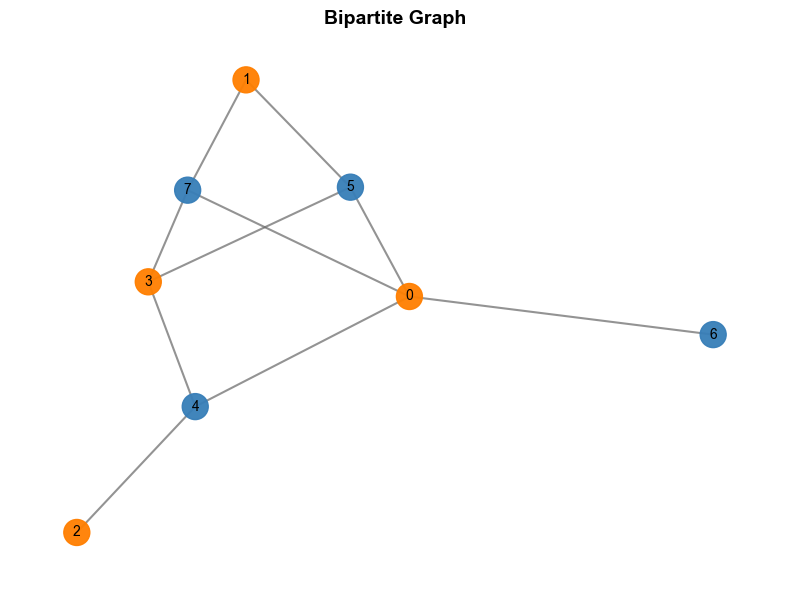

Adjacency matrix: 
[[0 0 0 1 1 1 0 0]
 [0 0 0 1 1 1 0 1]
 [0 0 0 1 0 1 1 0]
 [1 1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]
Flattened upper triag: [0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0]


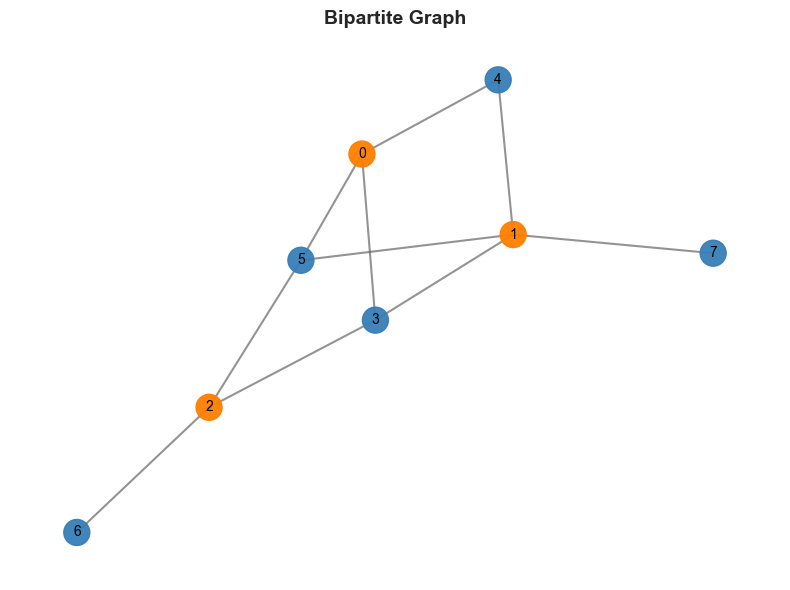

Adjacency matrix: 
[[0 0 0 0 1 1 1 1]
 [0 0 0 1 1 0 1 1]
 [0 0 0 1 0 1 1 0]
 [0 1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]]
Flattened upper triag: [0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0]


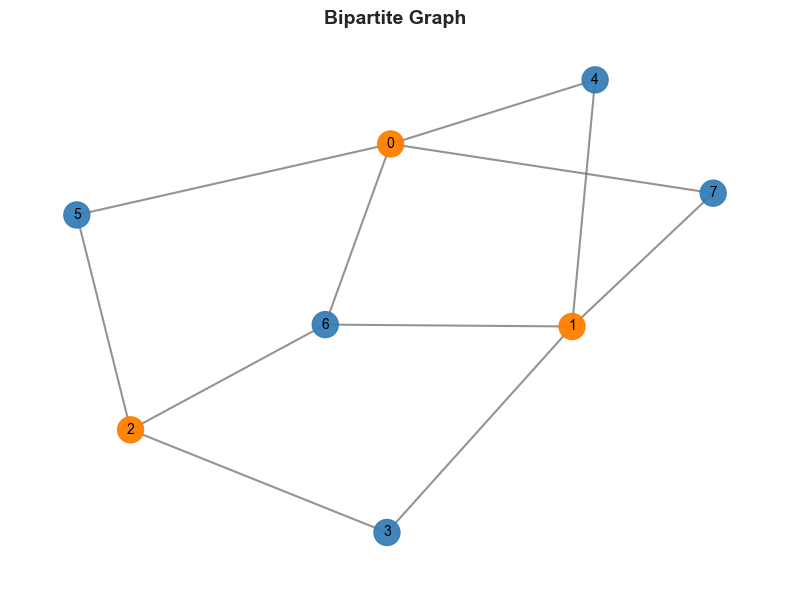

In [6]:
for _ in range(3):
    idx = np.random.randint(0, 303)
    print("Adjacency matrix: ")
    print(vec_to_adj(vector_version[idx], NODES))
    print("Flattened upper triag:", vector_version[idx])
    plot_graph(graphs[idx])

In [7]:
train_ds = jnp.array(vector_version[:200])

# IQP Model

In [8]:
import iqpopt as iqp
from iqpopt.utils import initialize_from_data
from iqpopt.gen_qml.utils import median_heuristic

from utils.nisq import aachen_connectivity, efficient_connectivity_gates
from utils import metrics
from datasets.utils import vec_to_graph

import jax

In [9]:
num_qubits = NODES * (NODES -1) // 2
num_layers = 1

In [10]:
parametrized_gates = efficient_connectivity_gates(aachen_connectivity(), num_qubits, num_layers=num_layers)
print(parametrized_gates)
print(len(parametrized_gates))

[[[np.int64(0)]], [[np.int64(1)]], [[np.int64(2)]], [[np.int64(3)]], [[np.int64(4)]], [[np.int64(5)]], [[np.int64(6)]], [[np.int64(7)]], [[np.int64(8)]], [[np.int64(9)]], [[np.int64(10)]], [[np.int64(11)]], [[np.int64(12)]], [[np.int64(13)]], [[np.int64(14)]], [[np.int64(15)]], [[np.int64(16)]], [[np.int64(17)]], [[np.int64(18)]], [[np.int64(19)]], [[np.int64(20)]], [[np.int64(21)]], [[np.int64(22)]], [[np.int64(23)]], [[np.int64(24)]], [[np.int64(25)]], [[np.int64(26)]], [[np.int64(27)]], [[np.int64(0), np.int64(1)]], [[np.int64(1), np.int64(2)]], [[np.int64(2), np.int64(3)]], [[np.int64(3), np.int64(4)]], [[np.int64(3), np.int64(16)]], [[np.int64(4), np.int64(5)]], [[np.int64(5), np.int64(6)]], [[np.int64(6), np.int64(7)]], [[np.int64(7), np.int64(8)]], [[np.int64(7), np.int64(17)]], [[np.int64(8), np.int64(9)]], [[np.int64(9), np.int64(10)]], [[np.int64(10), np.int64(11)]], [[np.int64(11), np.int64(12)]], [[np.int64(11), np.int64(18)]], [[np.int64(12), np.int64(13)]], [[np.int64(13)

In [11]:
initial_parameters = initialize_from_data(parametrized_gates, train_ds)
print(initial_parameters)
print(len(initial_parameters))

[ 1.22782759e-01  3.83497000e-01  8.15416157e-01  9.01437044e-01
  8.45543087e-01  8.60682309e-01  8.30459118e-01  3.38065267e-01
  8.15416157e-01  8.30459118e-01  8.60682309e-01  7.75397480e-01
  7.85398126e-01  6.79610610e-01  6.69359326e-01  6.99983299e-01
  7.25253224e-01  7.05052793e-01  1.41897053e-01  1.41897053e-01
  1.41897053e-01  1.22782759e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.21073146e-01  4.72032011e-01  4.45212011e-01  2.39081149e-01
 -3.15709722e-01 -1.83908576e-01  4.08047153e-01  7.66285733e-04
  1.79310861e-01 -7.08048017e-01  1.76245718e-02  3.31418579e-01
  2.03065719e-01  7.66285733e-01  1.56322289e-01  3.44828580e-01
  6.57856301e-01  4.63219725e-01  1.02682288e-01  0.00000000e+00
  0.00000000e+00  1.48659432e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
56


In [12]:
loss = iqp.gen_qml.mmd_loss_iqp
learning_rate = 0.0044
sigma = median_heuristic(train_ds)
print(sigma)

2.8284271247461903


In [13]:
iqp_circuit = iqp.IqpSimulator(num_qubits, parametrized_gates, device='lightning.qubit')

/var/folders/6q/mzgmvrhn3l76p312t6zn3mxw0000gn/T/ipykernel_80944/942165042.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


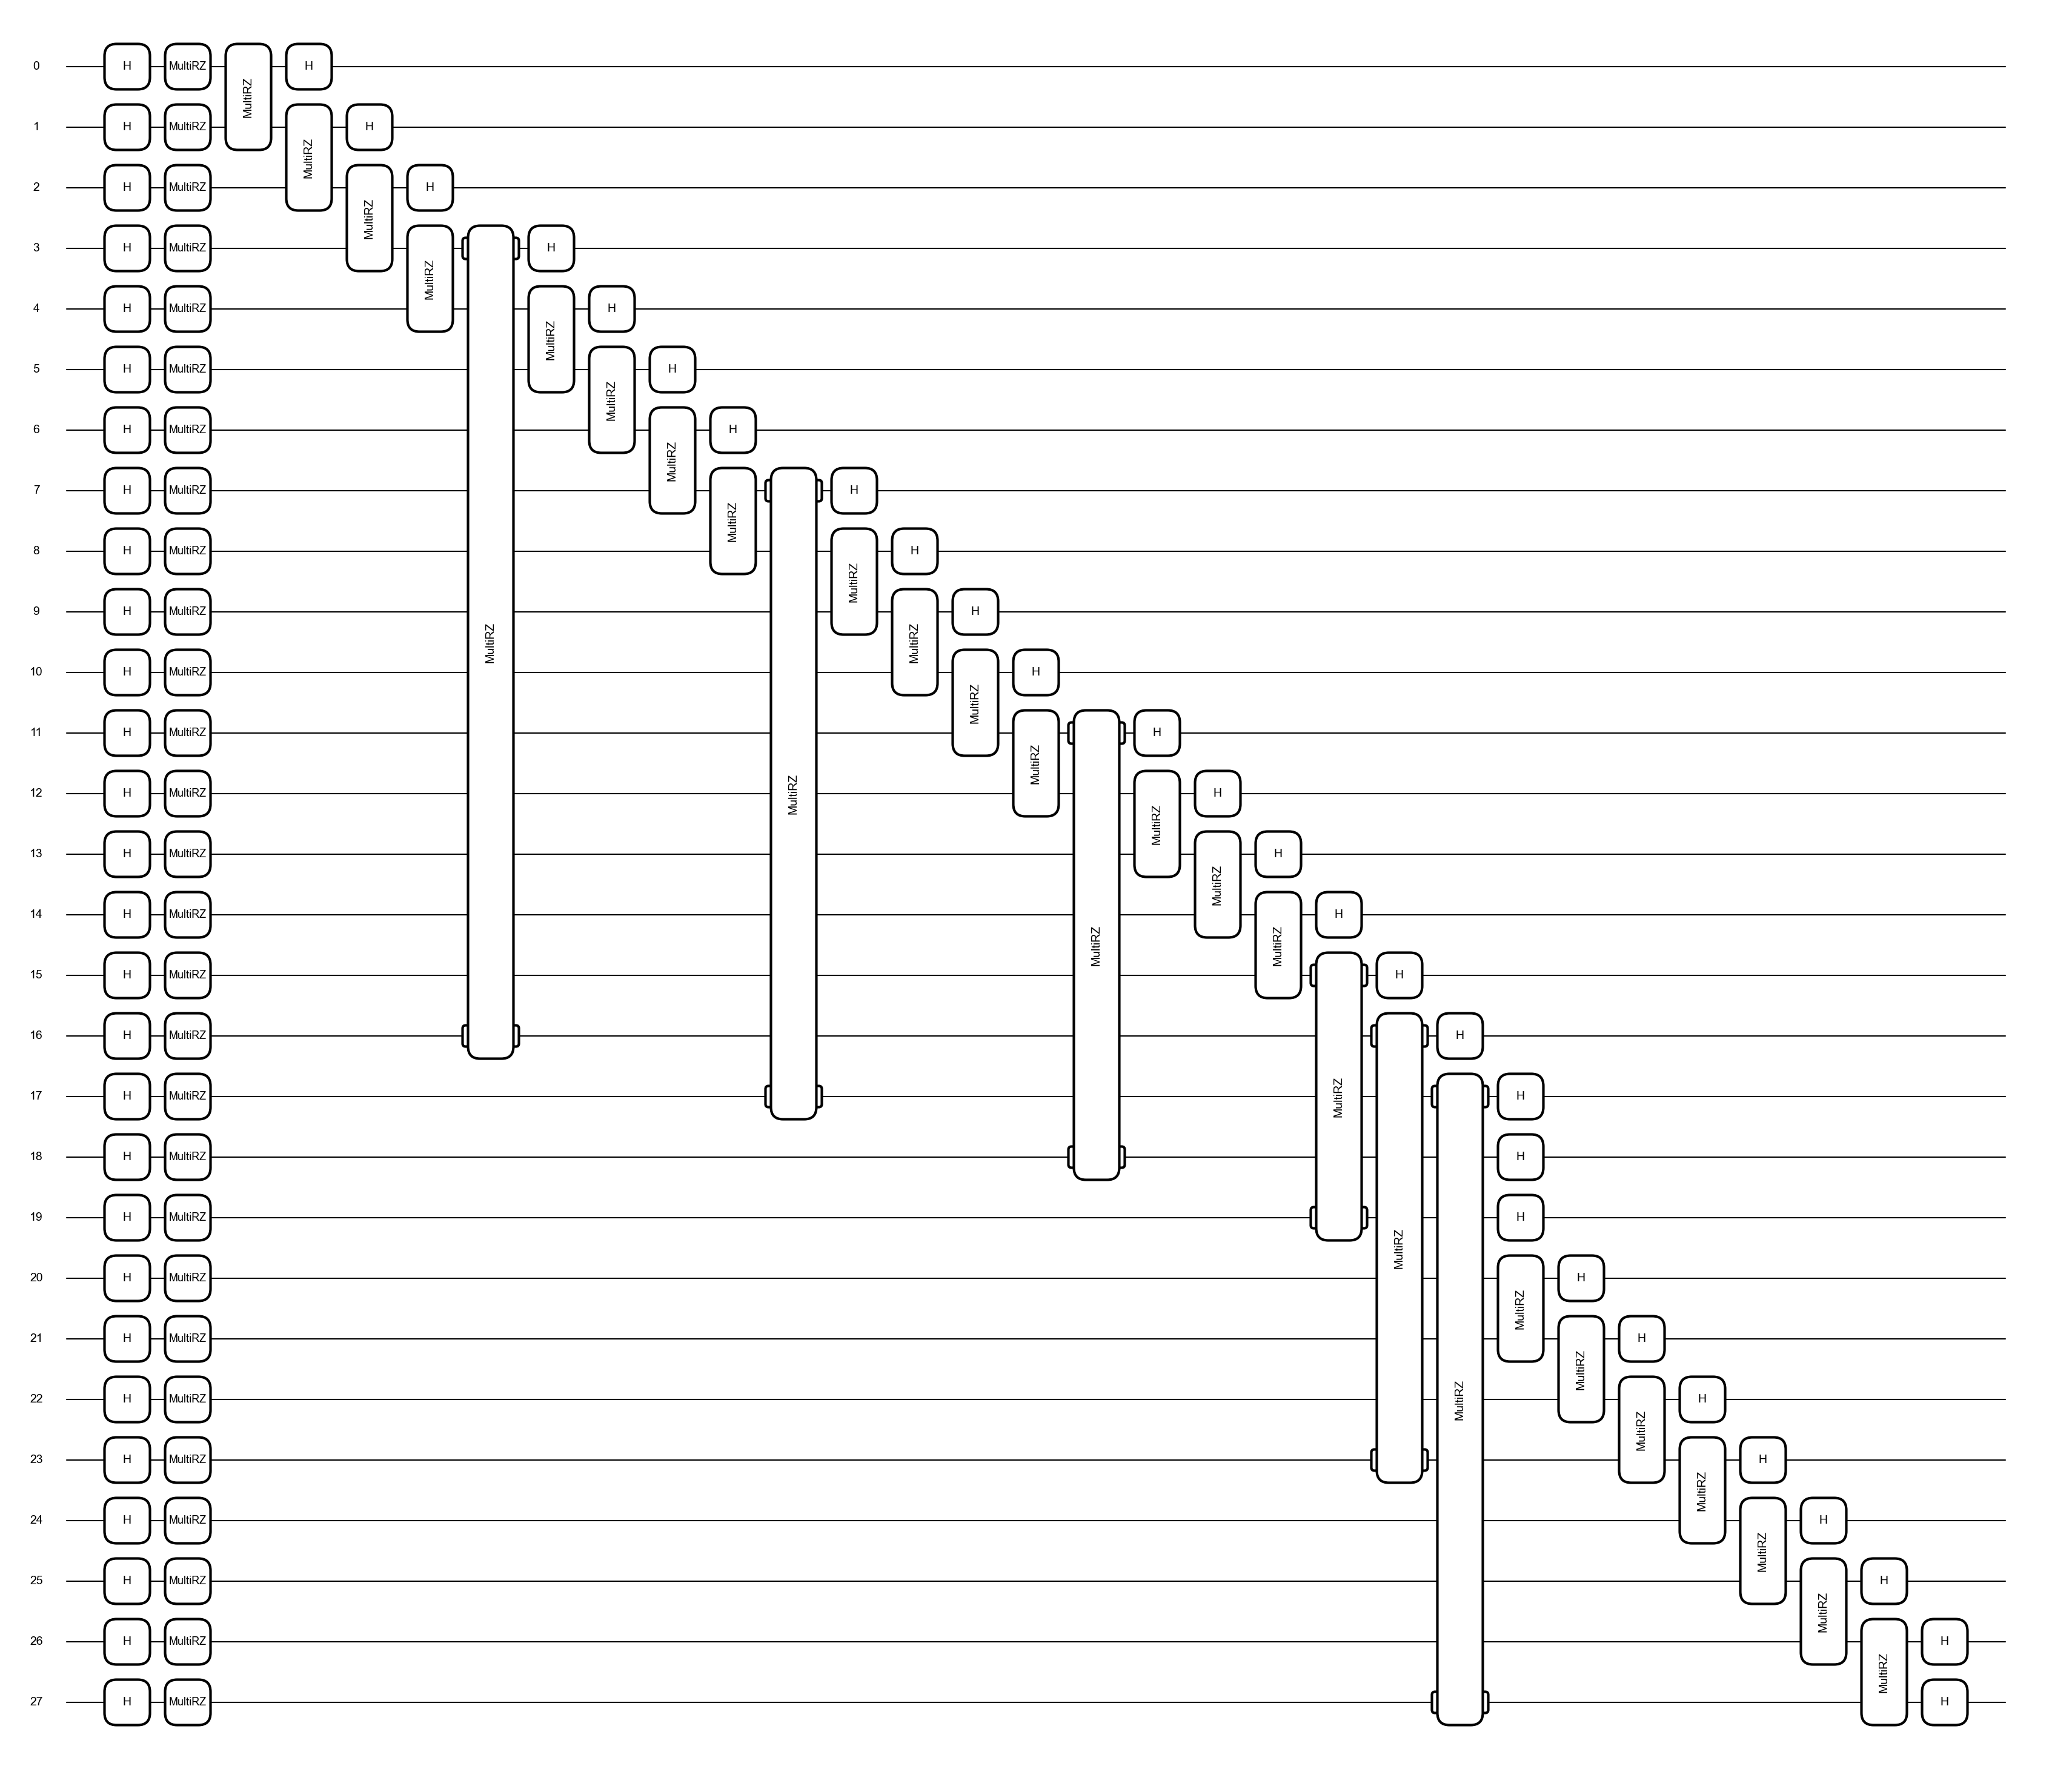

In [14]:
fig, ax = qml.draw_mpl(iqp_circuit.iqp_circuit)(initial_parameters)
fig.show()

In [15]:
loss_kwarg = {
    "params": initial_parameters,
    "iqp_circuit": iqp_circuit,
    "ground_truth": train_ds,
    "sigma": [sigma],
    "n_ops": 2000,
    "n_samples": 2000,
    "key": jax.random.PRNGKey(42),
}

In [16]:
trainer = iqp.Trainer("Adam", loss, stepsize=learning_rate)
trainer.train(n_iters= 2000,loss_kwargs=loss_kwarg, turbo=1)

Training Progress: 100%|██████████| 2000/2000 [00:36<00:00, 55.06it/s, loss=-0.000962, elapsed time=0.02, total time=37]  


Training has not converged after 2000 steps


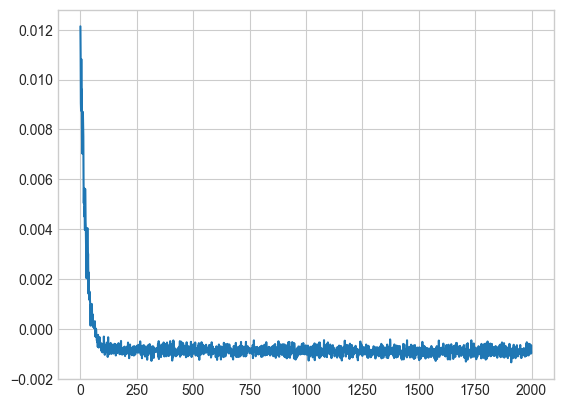

In [17]:
trained_params = trainer.final_params

plt.plot(trainer.losses)
plt.show() 

In [18]:
samples = iqp_circuit.sample(trained_params, shots = 1000)

In [19]:
print(samples[0])

[0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [20]:
prop_bipart = metrics.bipartite_proportion(samples, NODES) 

In [21]:
print(prop_bipart * 100, "% bipartites")

78.60000000000001 % bipartites


In [22]:
graph_samples = [vec_to_graph(g, NODES) for g in samples]
ground_truth = [vec_to_graph(g, NODES) for g in train_ds]

In [23]:
generated_bipartite = metrics.filter_bipartite(graph_samples)

In [24]:
metrics.sample_diversity(generated_bipartite)

(163, 1.0)

In [25]:
metrics.sample_diversity(ground_truth)

(200, 1.0)

In [29]:
metrics.average_kl_divergence(graphs, graph_samples)

4.320812366560226

In [27]:
metrics.memorized_proportion(ground_truth, generated_bipartite)

=== Memorization Report ===
Ground‐truth graphs:       200
Generated graphs:          163
Generated ⟶ GT matches:    157/163 (96.32%)
GT ⟵ Generated coverage:   157/200 (78.50%)


{'n_truth': 200,
 'n_gen': 163,
 'gen_mem_count': 157,
 'gen_mem_fraction': 0.9631901840490797,
 'truth_cov_count': 157,
 'truth_cov_fraction': 0.785}

In [30]:
metrics.analyze_model_vs_dataset(graphs, generated_bipartite);


=== Model vs Dataset Analysis ===

1) Basic sizes & uniqueness
   GT graphs       : 303
   Generated graphs: 163
   GT unique-adj  : 303
   Gen unique-adj : 163
   GT unique-iso  : 303
   Gen unique-iso : 163

2) Structural statistics (GT vs Gen)
   Metric               GT       Gen       Δ        Ratio
   Avg edges               8.33     7.69    -0.64      0.92
   Avg density             0.30     0.27    -0.02      0.92
   Conn. frac              0.60     0.47    -0.13      0.79
   #Comp                   1.68     1.90     0.22      1.13
   Bip frac                1.00     1.00     0.00      1.00
   Bip density             0.57     0.53    -0.04      0.93

3) Memorization & coverage
   Precision (Gen→GT): 100.00%
   Recall    (GT←Gen): 53.80%
   Novel gen        : 0/163 ( 0.00%)
   GT never seen    : 140/303 (46.20%)
   Matches per GT   : avg 1.00, med 1.00, min 1, max 1

4) Degree distribution divergences
   KL(GT→Gen)        : 0.0214
   KL(Gen→GT)        : 0.0152
   JS sym         